- Randomly generate center, number of angles, spin angle, scaling
- Draw and fill
- Circle, 3-8

In [ ]:
import pickle
import numpy as np
import pandas as pd
from functools import partial
import drawSvg as draw
import matplotlib.pyplot as plt
from imageio import imread

from tensorflow import keras

In [364]:
# 0 - circle
shapes = {0: {'origin': partial(np.random.uniform, low=-20, high=20, size=2),
              'scale': partial(np.random.uniform, low=10, high=20, size=1)},
          **{N: {'origin': partial(np.random.uniform, low=-20, high=20, size=2),
                 'spin': partial(np.random.uniform, low=0, high=2 * np.pi, size=1),
                 'scale': partial(np.random.uniform, low=10, high=20, size=1)} for N in range(3, 7)}}

In [425]:
def generator(shapes, dpi=50):
    
    while True:

        N = np.random.choice(list(shapes.keys()))
        if N == 0:
            scale = shapes[N]['scale']()[0]
            origin = shapes[N]['origin']()
            if np.all(np.abs(np.array(
                [origin[0] - scale, origin[0] + scale,
                 origin[1] - scale, origin[1] + scale])) <= int(dpi / 2)):
                d = draw.Drawing(dpi, dpi, origin='center', displayInline=False)
                d.append(draw.Circle(*origin, scale, fill='black'))
                yield d, N
        else:
            spin = shapes[N]['spin']()[0]
            scale = shapes[N]['scale']()[0]
            origin = shapes[N]['origin']()

            rad = [scale * np.exp((2 * np.pi / N * n + spin) * 1j) for n in range(N)]
            coord = [i for c in [[origin[0] + c.real, origin[1] + c.imag] for c in rad] for i in c]

            # Draw an irregular polygon
            if np.all(np.abs(np.array(coord)) <= int(dpi / 2)):
                d = draw.Drawing(dpi, dpi, origin='center', displayInline=False)
                d.append(draw.Lines(*coord, close=True, fill='black'))
                yield d, N

gen = generator(shapes)

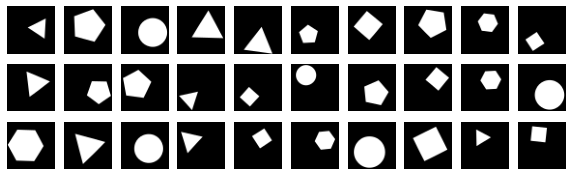

In [426]:
plt.figure(figsize=(10, 3))
for i in range(30):
    d, N = next(gen)
    d.savePng('tmp.png')
    plt.subplot(3, 10, i + 1)
    plt.imshow(imread('tmp.png')[:, :, 3], cmap='gray')
    plt.axis('off')
plt.show()

# Training examples

In [420]:
def batch_gen(batch_sice=32, dim=50, gen=generator(shapes)):
    while True:
        X = np.zeros((batch_sice, dim, dim, 1))
        y = np.zeros((batch_sice))
        for i in range(batch_sice):
            d, N = next(gen)
            # Fix class label
            y[i] = 0 if N == 0 else N - 2
            d.savePng('tmp.png')
            # Rescale
            X[i] = imread('tmp.png')[:, :, [3]] / 255
        yield X, y

gen = batch_gen()

In [421]:
def get_model(hidden):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[50, 50, 1]))
    model.add(keras.layers.Dense(hidden, activation="relu"))
    model.add(keras.layers.Dense(hidden, activation="relu"))
    model.add(keras.layers.Dense(6, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="sgd",
                  metrics=["accuracy"])
    return model

Epoch 1/20
100/100 [==============================] - 17s 173ms/step - loss: 1.6635 - accuracy: 0.2209
Epoch 2/20
100/100 [==============================] - 16s 161ms/step - loss: 1.5629 - accuracy: 0.2887
Epoch 3/20
100/100 [==============================] - 16s 161ms/step - loss: 1.5133 - accuracy: 0.3388
Epoch 4/20
100/100 [==============================] - 17s 174ms/step - loss: 1.4919 - accuracy: 0.3388
Epoch 5/20
100/100 [==============================] - 18s 182ms/step - loss: 1.4611 - accuracy: 0.3522
Epoch 6/20
100/100 [==============================] - 20s 197ms/step - loss: 1.4426 - accuracy: 0.3506
Epoch 7/20
100/100 [==============================] - 21s 211ms/step - loss: 1.4316 - accuracy: 0.3444
Epoch 8/20
100/100 [==============================] - 19s 193ms/step - loss: 1.4267 - accuracy: 0.3422
Epoch 9/20
100/100 [==============================] - 18s 178ms/step - loss: 1.4035 - accuracy: 0.3525
Epoch 10/20
100/100 [==============================] - 20s 203ms/step - l

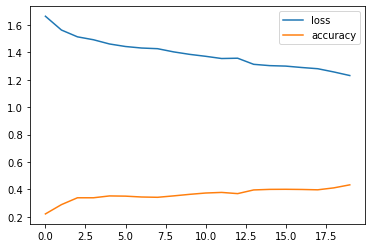

In [422]:
model = get_model(100)
loss = model.fit(gen, epochs=20, steps_per_epoch=100)

pd.DataFrame(loss.history).plot()

In [415]:
def get_cnn_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=[50, 50, 1]))
    model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.Dense(6, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    return model

Epoch 1/20
100/100 [==============================] - 27s 268ms/step - loss: 1.5422 - accuracy: 0.2912
Epoch 2/20
100/100 [==============================] - 25s 246ms/step - loss: 1.3400 - accuracy: 0.4006
Epoch 3/20
100/100 [==============================] - 26s 260ms/step - loss: 1.2492 - accuracy: 0.4241
Epoch 4/20
100/100 [==============================] - 22s 217ms/step - loss: 1.1158 - accuracy: 0.4831
Epoch 5/20
100/100 [==============================] - 24s 240ms/step - loss: 1.0036 - accuracy: 0.5450
Epoch 6/20
100/100 [==============================] - 26s 259ms/step - loss: 0.8526 - accuracy: 0.6175
Epoch 7/20
100/100 [==============================] - 25s 246ms/step - loss: 0.7640 - accuracy: 0.6456
Epoch 8/20
100/100 [==============================] - 24s 236ms/step - loss: 0.6575 - accuracy: 0.7169
Epoch 9/20
100/100 [==============================] - 29s 288ms/step - loss: 0.5826 - accuracy: 0.7450
Epoch 10/20
100/100 [==============================] - 24s 241ms/step - l

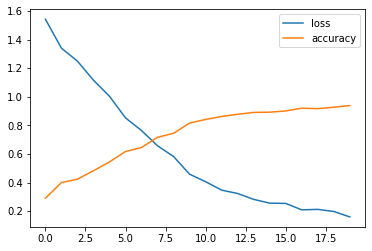

In [416]:
model = get_cnn_model()
loss = model.fit(gen, epochs=20, steps_per_epoch=100)

pd.DataFrame(loss.history).plot()

Data is complex enough so that simple models will fail. CNN's work nicely, but to get accuracy above 95 will be challenging.

Idea: to test best students just change random generator functions a bit for train and validation sets. For example circles could show up only on the left side in the train set, but on both sides in validation set.

# Train data dump

In [ ]:
def data_dump(size, dim=50, gen=generator(shapes)):
    X = np.zeros((size, dim, dim))
    y = np.zeros((size))
    for i in range(size):
        d, y[i] = next(gen)
        d.savePng('tmp.png')
        X[i] = imread('tmp.png')[:, :, 3]
    return X, y

X, y = data_dump(10)

In [ ]:
pickle.dump(open('flatland.pickle', 'wb'), (X, y))

In [ ]:
pickle.load(open('flatland.pickle', 'rb'))

I can make automated submit later, before the course starts.